### How big is my DataFrame?
`df.info()` , `df.memory_usage()`

### NumPy transformations
- Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.
- The function memory_footprint() has been provided to return the total amount of memory (in megabytes or MB) currently in use by our program. This function uses the psutil and os modules.

In [9]:
import numpy as np
import psutil, os
import matplotlib.pyplot as plt

def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 **2)

In [2]:
N = (1024 **2) //8 # number of floats that fill 1 MB
celsius = np.random.randn(50 * N) # Random array filling 50MB

# Print the size in MB of the celsius array
print(celsius.nbytes / 1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius * 9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)

50.0
50.0546875


### Computing percentage of delayed flights
- build a function to compute the percentage of delayed flights given a DataFrame of flight information. 


In [7]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY'] > 0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)


### Generating & plotting delayed flights

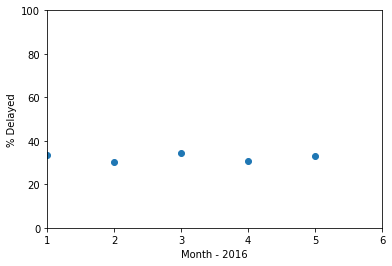

In [13]:
# Define the generator: dataframes
filenames = glob.glob('../data/flightdelays/*.csv')
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

# Create the plot
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,6))
plt.ylim((0,100))
plt.show()

### Building a pipeline with delayed
- If we use `dask.delayed`, we don't need to use generators; the dask scheduler will manage memory usage.
- **Task** : define three decorated functions to complete the pipeline: a function to total the number of flights, a function to count the number of delayed flights, and a function to aggregate the results.

In [3]:
from dask import delayed
import os 
import glob
import pandas as pd

C:\Users\Shubham\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

- These functions constitute the pieces of the pipeline for our flight-delay analysis

### Computing pipelined results
- Now that the dask.delayed functions are defined, we can use them to construct the pipeline of delayed tasks.
-  loop over the file names, store the temporary information in lists, and aggregate the final result.
- The distinction here is that we are working with `dask.delayed` functions and objects, not real, computed values. The computation will only be executed when we call `.compute()` on the final result.

In [5]:
filenames = glob.glob('../data/flightdelays/*.csv')
filenames

['../data/flightdelays\\flightdelays-2016-1.csv',
 '../data/flightdelays\\flightdelays-2016-2.csv',
 '../data/flightdelays\\flightdelays-2016-3.csv',
 '../data/flightdelays\\flightdelays-2016-4.csv',
 '../data/flightdelays\\flightdelays-2016-5.csv']

In [6]:
n_delayed = []
n_flights = []
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = pd.read_csv(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824


- Notice that no reading and no computation was done until the last line (result.compute()). In all the preceding lines, the functions called returned dask.delayed objects that deferred execution until the invocation of compute().